In [1]:
%matplotlib inline

/Users/shoji/go/src/github.com/mikanfactory/CanDataAnalyzer/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import json
import pprint
from sklearn.mixture import BayesianGaussianMixture
from skbayes.mixture_models import VBBMM

In [3]:
import seaborn as sns
sns.set(color_codes=True)

# Preprocess

In [22]:
targetDir = "../data/output/d3/Result/"
speedDir = "../data/output/d3/Speed/"
brakeDir = "../data/output/d3/Brake/"
accelDIr = "../data/output/d3/Accel/"
steeringPositiveDir = "../data/output/d3/SteeringPositive/"
steeringNegativeDir = "../data/output/d3/SteeringNegative/"
aheadDistance = "../data/output/d3/AheadDistance/"
relativitySpeed = "../data/output/d3/AheadRelativitySpeed/"

In [23]:
df1 = pd.read_csv(speedDir + "result.csv")
df2 = pd.read_csv(brakeDir + "result.csv")
df2.columns = [["id", "brake"]]
df3 = pd.read_csv(accelDIr + "result.csv")
df3.columns = [["id", "accel"]]
df4 = pd.read_csv(steeringPositiveDir + "result.csv")
df4.columns = [["id", "steeringPositive"]]
df5 = pd.read_csv(steeringNegativeDir + "result.csv")
df5.columns = [["id", "steeringNegative"]]
df6 = pd.read_csv(aheadDistance + "result.csv")
df6.columns = [["id", "near", "intermediate", "far"]]
df7 = pd.read_csv(relativitySpeed + "result.csv")
df7.columns = [["id", "moderate", "slower", "little faster", "faster"]]

In [24]:
df = pd.merge(pd.merge(pd.merge(pd.merge(df1, df2, on="id"), df3, on="id"), df4, on="id"), df5, on="id")
df = pd.merge(pd.merge(df, df6, on="id"), df7, on="id")
gridSize = len(df)

In [25]:
mf = df[df['red'] + df['yellow'] + df['green'] + df['stop'] > 0]
mf = mf[["red", "yellow", "green", "stop", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]
mf.columns = ["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]

In [26]:
mf.describe()

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,moderate,slower,little faster,faster
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000
mean,2.721154,1.692308,0.567308,1.240385,2.028846,1.490385,0.884615,0.557692,1.048077,1.836538,1.298077,3.163462,0.105769,0.365385,0.557692
std,3.281181,1.520583,1.121411,5.162402,3.454157,3.075096,2.815725,2.715747,4.569591,1.712947,1.694536,5.411442,0.438848,0.683476,0.953552
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000
75%,3.000000,3.000000,0.250000,0.000000,3.000000,2.000000,1.000000,0.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,1.000000
max,30.000000,5.000000,4.000000,36.000000,30.000000,28.000000,27.000000,27.000000,36.000000,8.000000,13.000000,39.000000,3.000000,4.000000,4.000000


In [27]:
colors = [
    "#ff0000",
    "#ffa500",
    "#ffff00",
    "#008000",
    "#00ffff",
    "#0000ff",
    "#800080"
]

In [28]:
colors13 = [
    "#f39700",
    "#e60012",
    "#9caeb7",
    "#00a7db",
    "#009944",
    "#d7c447",
    "#967cb6",
    "#00ada9",
    "#bb641d",
    "#e85298",
    "#0079c2",
    "#6cbb5a",
    "#b6007a"
]

# VBGMM

In [29]:
bf = mf.copy()
bf["sum"] = bf["red"] + bf["yellow"] + bf["green"] + bf["slow"] + bf["brake"] + bf["accel"] + bf["steeringPositive"] + bf["steeringNegative"] + bf["near"] + bf["intermediate"] + bf["far"] + bf["moderate"] + bf["slower"] +  bf["little faster"] + bf["faster"]
for key in mf.columns:
    if key == "sum":
        continue
    bf[key] = bf[key] / bf["sum"]

bf = bf[["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]

In [30]:
components = 7
prior = 0.1

In [31]:
def gridSearch():
    result = []
    for k in range(20):
        sd = k
        np.random.seed(sd)
        random.seed(sd)
    
        vb = BayesianGaussianMixture(n_components=components, weight_concentration_prior=prior, max_iter=200).fit(bf)
        result.append({
                "seed": sd,
                "classes": len(set(vb.predict(bf))),
                "lower bounds": vb.lower_bound_
        })

    return sorted(result, key=lambda res: res["lower bounds"])

# pprint.pprint(gridSearch())

In [32]:
sd = 8
np.random.seed(sd)
random.seed(sd)

In [33]:
vb = BayesianGaussianMixture(n_components=components, weight_concentration_prior=prior, max_iter=200).fit(bf)
print "classes:          ", set(vb.predict(bf))
print "lower bound: ", vb.lower_bound_

classes:           set([0, 1, 2, 3, 4, 5, 6])
lower bound:  11855.0070641


In [34]:
vb.weights_

array([ 0.35280264,  0.22515152,  0.09177935,  0.08931582,  0.08613175,
        0.12202603,  0.03279288])

In [35]:
ref = pd.DataFrame(vb.means_)
ref.columns = [["red", "yellow", "green", "slow", "brake", "accel", "steeringPositive",  "steeringNegative", "near", "intermediate", "far", "moderate", "slower", "little faster", "faster"]]
ref

,red,yellow,green,slow,brake,accel,steeringPositive,steeringNegative,near,intermediate,far,moderate,slower,little faster,faster
0,0.076991,0.242613,0.021665,0.000395,0.051816,0.025901,0.000622,0.000299,0.000336,0.232465,0.057047,0.259118,0.000082,0.016529,0.014121
1,0.139597,0.051268,0.054886,0.064079,0.135610,0.106790,0.064960,0.034559,0.054527,0.080753,0.038750,0.126484,0.013344,0.025414,0.008978
2,0.330390,0.011896,0.002107,0.001465,0.136681,0.087365,0.010639,0.001108,0.001246,0.046151,0.161776,0.091120,0.000305,0.067052,0.050700
3,0.320699,0.011893,0.002107,0.001464,0.017193,0.005296,0.002304,0.001108,0.001246,0.012810,0.304910,0.266892,0.000305,0.047042,0.004732
4,0.321835,0.011893,0.002107,0.001464,0.020602,0.005296,0.002304,0.001108,0.001246,0.029477,0.285971,0.034064,0.000305,0.019264,0.263065
5,0.145239,0.167539,0.008997,0.000979,0.125907,0.081101,0.053482,0.023062,0.000833,0.095834,0.100177,0.090801,0.000204,0.020146,0.085696
6,0.301945,0.023843,0.004215,0.002930,0.038372,0.032758,0.004608,0.002216,0.002493,0.270111,0.021948,0.279288,0.000610,0.005196,0.009466


# Plot histgram of each clusters

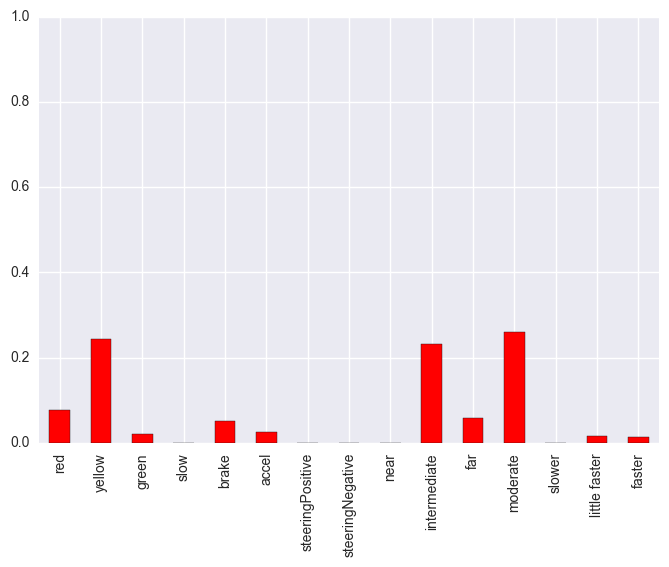

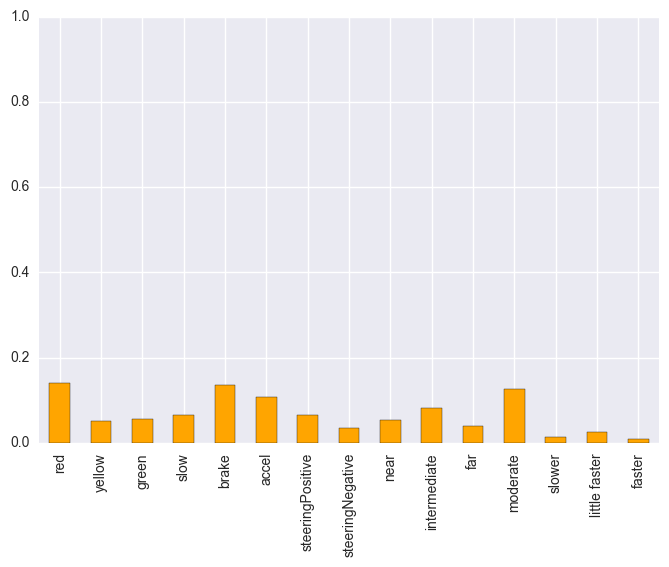

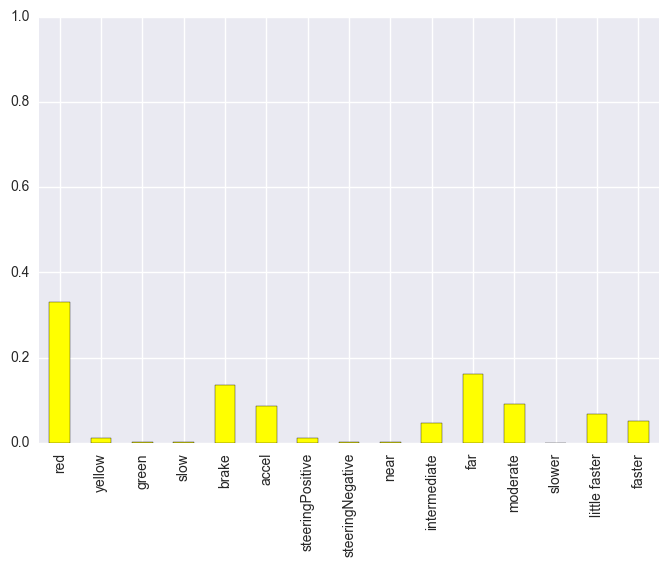

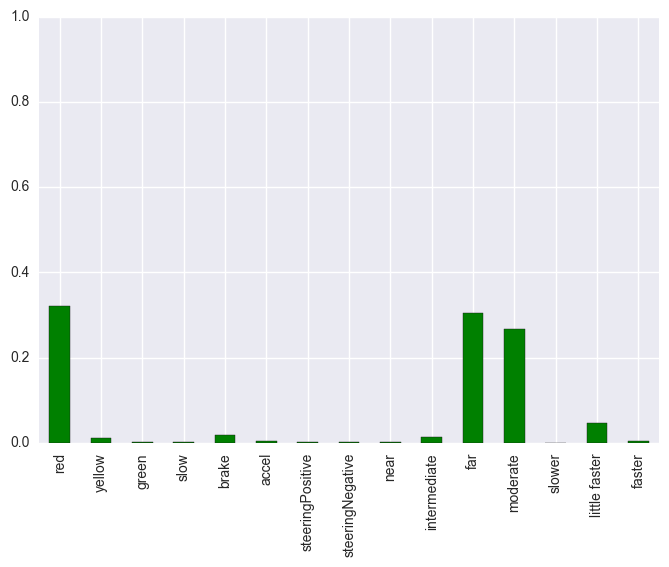

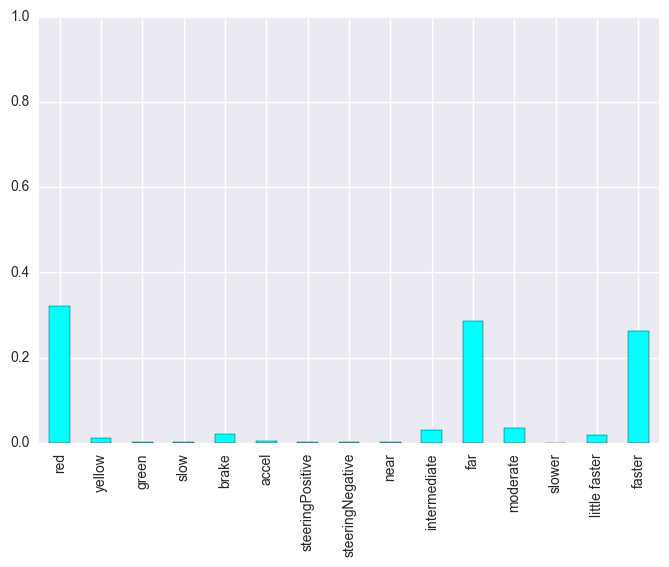

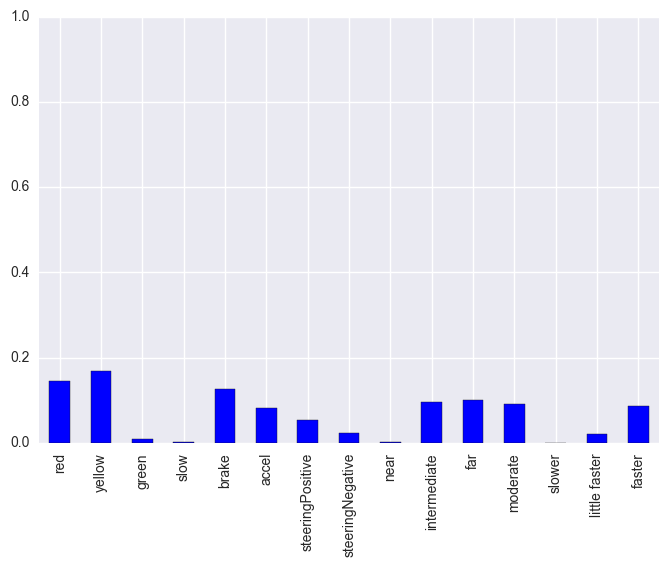

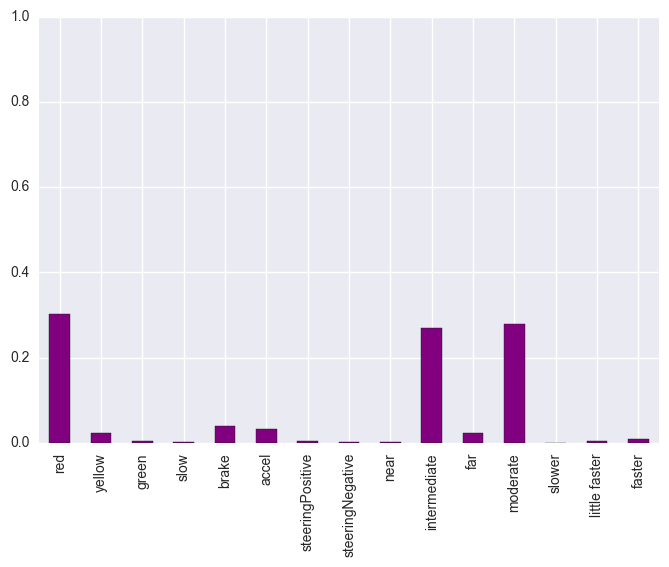

In [36]:
dir = "./img/d3/clusters-" + str(sd)
if not os.path.exists(dir):
    os.mkdir(dir)
    
resLength = len(set(vb.predict(bf)))
for i in range(resLength):
    ref.ix[i].plot(kind='bar', color=colors[i])
    plt.ylim(0, 1)
    plt.savefig(dir + "/cluster" + str(i) + ".png")
    plt.show()

# Save

In [41]:
pred = zip(mf.index, vb.predict(bf))
result = np.zeros(gridSize)

for index, klass in pred:
    result[index] = klass + 1
    
np.savetxt(targetDir + "clusters.csv", result, delimiter=",", fmt="%d")

with open(dir + '/VBSetting.json', 'w') as outfile:
    data = {
        "n_components": components,
        "weight_concentration_prior": prior,
        "seed": sd
    }
    json.dump(data, outfile)